<a href="https://colab.research.google.com/github/DarinaVerk/Meds_Review_XLNET_Regression/blob/main/Meds_Review_XLNET_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pytorch-transformers
!pip install transformers

In [ ]:
%%capture
!pip install umap-learn

In [ ]:
%%capture
!pip install hdbscan

In [ ]:
%%capture
!pip install bigartm

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import re, string
import os
import math

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from tqdm.notebook import trange, tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import AdamW, XLNetModel, TFXLNetModel, \
                            XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification, Trainer


In [ ]:
from transformers import AutoTokenizer, AutoModel

In [ ]:
from pytorch_transformers import XLNetTokenizer

In [ ]:
from sklearn.model_selection import train_test_split

# Data Loading

In [ ]:
#Columns
cols = ['review', 'rating']
#Data types
dtypes = {cols[0]: pd.StringDtype() , cols[1]: 'float32'}

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Kaggle_data/data_meds/drugsComTrain_raw.csv',
                        usecols = cols,
                        encoding = 'utf8',
                        dtype = dtypes
                        )

df_test = pd.read_csv('/content/drive/MyDrive/Kaggle_data/data_meds/drugsComTest_raw.csv',
                        usecols = cols,
                        encoding = 'utf8',
                        dtype = dtypes
                        )

In [ ]:
pd.options.display.max_colwidth = 200

In [ ]:
df_train

,review,rating
0,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0
1,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get ou...",8.0
2,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not ava...",5.0
3,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is...",8.0
4,"""Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone an...",9.0
...,...,...
161292,"""I wrote my first report in Mid-October of 2014. I have not had any alcohol at all since that post, have reduced my dosage to 1 pill first thing in the morning. I am a very social person, and en...",10.0
161293,"""I was given this in IV before surgey. I immediately became anxious and could not sit still . The PA said &quot;oh yes this happens sometimes&quot;. They had to give me Benadryl to calm me down. I...",1.0
161294,"""Limited improvement after 4 months, developed bad rash and MD refused to continue medication.""",2.0
161295,"""I&#039;ve been on thyroid medication 49 years, I spent my first 38 on Synthroid and various t4 formulas, I could not stand the up and down of Synthroid, it never was steady. Every time I went to ...",10.0


In [ ]:
df_test

,review,rating
0,"""I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed ...",10.0
1,"""My son has Crohn&#039;s disease and has done very well on the Asacol. He has no complaints and shows no side effects. He has taken as many as nine tablets per day at one time. I&#039;ve been v...",8.0
2,"""Quick reduction of symptoms""",9.0
3,"""Contrave combines drugs that were used for alcohol, smoking, and opioid cessation. People lose weight on it because it also helps control over-eating. I have no doubt that most obesity is caused ...",9.0
4,"""I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out ...",9.0
...,...,...
53761,"""I have taken Tamoxifen for 5 years. Side effects are severe sweating and depression. I have been taking Effexor XR longer than I have been on Tamoxifen. My Oncologist increased the Effexor dosage...",10.0
53762,"""I&#039;ve been taking Lexapro (escitaploprgram) since February. First, I&#039;d like to mention that you can NOT take this drug for a week or less and expect to magically feel better; I felt real...",9.0
53763,"""I&#039;m married, 34 years old and I have no kids. Taking the pill was such a hassle so I decided to get the Mirena. It was very painful when it was inserted,then had cramping for the rest of tha...",8.0
53764,"""I was prescribed Nucynta for severe neck/shoulder pain. After taking only 2, 75mg pills I was rushed to the ER with severe breathing problems. I have never had any issues with pain medicines befo...",1.0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   review  161297 non-null  string 
 1   rating  161297 non-null  float32
dtypes: float32(1), string(1)
memory usage: 1.8 MB


The training dataset consists of 161,297 drug reviews.

Each review is treated as a single sentence.

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  53766 non-null  string 
 1   rating  53766 non-null  float32
dtypes: float32(1), string(1)
memory usage: 630.2 KB


The test dataset consists of 53,766 drug reviews.

#Data Preprocessing

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer


In [ ]:
#Data cleaning
def text_clear(text, lower_=True, lemmatize=False):
    # Map underscores and dashes to spaces, and separate repeated punctuation marks (!, ?)
    x = {'_': ' ', '-': ' ',
         '!': ' !', '?': ' ?'
         }

    # Pattern to match specific cases: alphanumeric units (e.g., A123Mg) or "mg" standalone
    pattern = r'([A-Za-z]\d+[M-mG-g])|(?<=\d)mg(?=[\s,-]|$)'

    # Define characters to be removed, excluding emotional punctuation (!, ?)
    result = re.sub(r'[!?_-]', '', string.punctuation)

    # Define stop words: words with 2 or fewer characters (except 'no') + pronouns
    stop_ = [i for i in stopwords.words('english') if (len(i) <= 2) and (i != 'no')] + \
            ['this', 'that', 'those', 'these', 'there', 'his', 'her', 'she', 'their', 'they',
             'him', 'the', 'hers', 'it', 'and', 'we', 'us', 'our', 'ours']

    # Combine stop words with their title-case variants
    stop = set(stop_ + [i.title() for i in stop_])

    if lower_:
        # Convert text to lowercase if the `lower_` flag is True
        text = text.lower()

    # Remove HTML entities
    txt = re.sub(r"&#039;", " ", text)  # Replace "&#039;" with a space
    txt = re.sub(r"&quot;", " ", txt)   # Replace "&quot;" with a space

    # Remove all punctuation except emotional punctuation (!, ?)
    txt = txt.translate(str.maketrans('', '', result))

    # Replace underscores, dashes, and separate repeated punctuation (!, ?) based on the map `x`
    txt = txt.translate(str.maketrans(x))

    # Isolate "mg", "Mg", "MG", "mG" from words, numbers, and other symbols
    txt = re.sub(pattern, lambda x: x.group(1) or ' mg', txt, flags=re.I)

    # Tokenize the text into words
    word_list = nltk.word_tokenize(txt)

    # Remove stop words from the tokenized list
    tokens_wo_stopwords = [t for t in word_list if t not in stop]

    if lemmatize:
        # If the `lemmatize` flag is True, lemmatize the tokens
        lmtzr = WordNetLemmatizer()

        # Lemmatize for verbs ('v'), adverbs ('r'), and nouns ('n')
        for i in ('v', 'r', 'n'):
            tokens_wo_stopwords = [lmtzr.lemmatize(w, pos=i) if w not in ('less',) else w for w in tokens_wo_stopwords]

        # Join lemmatized tokens into a single string
        filtered_sentence = ' '.join([w for w in tokens_wo_stopwords])

    else:
        # If not lemmatizing, join the tokens into a single string
        filtered_sentence = ' '.join([w for w in tokens_wo_stopwords])

    return filtered_sentence

In [ ]:
df_train['review'] = df_train.review.apply(func = text_clear)

In [ ]:
df_test['review'] = df_test.review.apply(func = text_clear, args = (True, True))


In [ ]:
df_train

,review,rating
0,has no side effect take combination bystolic 5 mg and fish oil,9.0
1,son halfway through fourth week intuniv became concerned when began last week when started taking highest dose will for two days could hardly get out bed was very cranky and slept for nearly 8 hou...,8.0
2,used take another oral contraceptive which had 21 pill cycle and was very happy very light periods max 5 days no other side effects but contained hormone gestodene which not available us switched ...,5.0
3,first time using any form birth control glad went with patch have been for 8 months first decreased libido but subsided only downside made periods longer 5 6 days exact used only have periods for ...,8.0
4,suboxone has completely turned life around feel healthier excelling job and always have money pocket and savings account had none before suboxone and spent years abusing oxycontin paycheck was alr...,9.0
...,...,...
161292,wrote first report mid october 2014 have not had any alcohol all since post have reduced dosage 1 pill first thing morning very social person and entertained great deal was very very worried would...,10.0
161293,was given iv before surgey immediately became anxious and could not sit still pa said oh yes happens sometimes had give benadryl calm down was worst experience have had out control and jumpy,1.0
161294,limited improvement after 4 months developed bad rash and md refused continue medication,2.0
161295,been thyroid medication 49 years spent first 38 synthroid and various t4 formulas could not stand and down synthroid never was steady every time went dr was adjusted could not regulate and most dr...,10.0


In [ ]:
df_test

,review,rating
0,try few antidepressant over year citalopram fluoxetine amitriptyline but none help with depression insomnia amp anxiety doctor suggest change onto 45 mg mirtazapine medicine have save life thankfu...,10.0
1,son have crohn disease have do very well asacol have no complaint show no side effect have take many nine tablet per day one time be very happy with result reduce bout diarrhea drastically,8.0
2,quick reduction symptom,9.0
3,contrave combine drug be use for alcohol smoke opioid cessation people lose weight because also help control over eat have no doubt most obesity cause from sugarcarb addiction which just powerful ...,9.0
4,have be birth control for one cycle after read some review type similar birth control be bite apprehensive start im give birth control 9 out 10 have not be long enough for 10 far love birth contro...,9.0
...,...,...
53761,have take tamoxifen for 5 year side effect be severe sweat depression have be take effexor xr longer than have be tamoxifen oncologist increase effexor dosage from 75 mg 150 mg per day assure effe...,10.0
53762,be take lexapro escitaploprgram since february first like mention you can not take drug for week less expect magically feel well felt really sick first two week drug but you have give drug time fo...,9.0
53763,marry 34 year old have no kid take pill be such hassle decide get mirena be very painful when be insertedthen have cramp for rest day ! for first 6 week spot off then period just stop still get cr...,8.0
53764,be prescribe nucynta for severe neckshoulder pain after take only 2 75 mg pill be rush er with severe breathe problem have never have any issue with pain medicine before,1.0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA A100-SXM4-40GB'

#Task 1

As the model for the first task, we will fine-tune the XLNet model.

The first task is to predict the rating of a medical drug based on the review.


##Tokenization + Obtaining IDs




In [ ]:
#Extracting sentences
train_sents = df_train.review.values

In [ ]:
#Transforming the input according to the XLNet format for a single sentence
train_sents = [ sentence + '[CLS] [SEP] ' for sentence in train_sents]

In [ ]:
#Target values represent the ratings of the drugs
train_target = df_train.rating.values

In [ ]:
#Initializing the `XLNetTokenizer`.
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

100%|██████████| 798011/798011 [00:00<00:00, 2517894.97B/s]


In [ ]:
#Tokenizing the sentences.
train_tok_texts = [tokenizer.tokenize(sent) for sent in tqdm(train_sents)]

print ("Tokenize the first sentence:")
print (train_tok_texts[0])

  0%|          | 0/161297 [00:00<?, ?it/s]

Tokenize the first sentence:
['▁has', '▁no', '▁side', '▁effect', '▁take', '▁combination', '▁by', 'st', 'olic', '▁5', '▁mg', '▁and', '▁fish', '▁oil', '[', 'cl', 's', ']', '▁[', 's', 'ep', ']']


In [ ]:
#Lengths of tokenized sentences.
lenght = [len(i) for i in train_tok_texts]

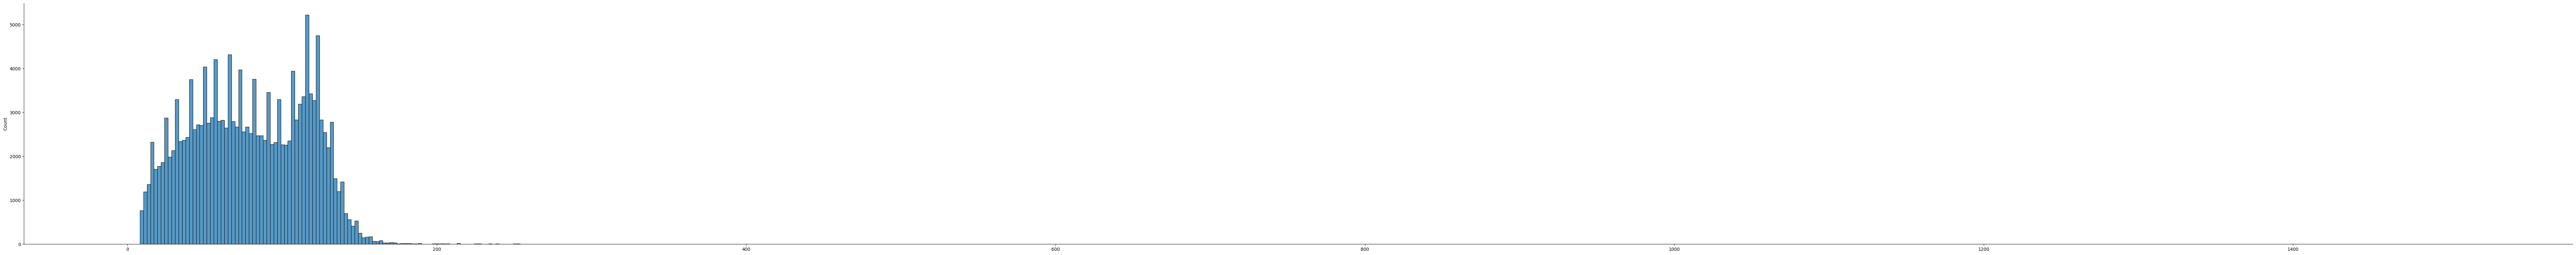

In [ ]:
sns.displot(lenght, aspect = 10);

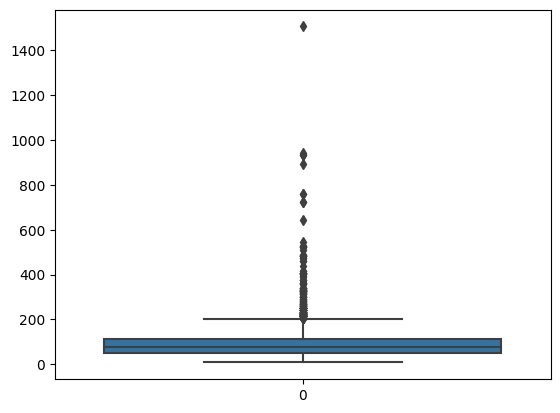

In [ ]:
sns.boxplot(lenght);

The lengths of sentences after tokenization are mostly distributed between 0 and 200.

We select 256 as the maximum sentence length.

In [ ]:
MAX_LEN = 256

In [ ]:
#Obtaining token IDs for the sentences
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(train_tok_texts)]

  0%|          | 0/161297 [00:00<?, ?it/s]

In [ ]:
import torch.nn.functional as F
import torchtext

In [ ]:
#Converting token IDs to equal lengths (truncate + padding) and transforming them into tensors
def pad_seqs(ids, max_len):
    ids_ = torchtext.functional.truncate(ids, max_seq_len = max_len)
    ids_ = torchtext.functional.to_tensor(ids_, padding_value = 0, dtype = torch.int64)
    return ids_

In [ ]:
input_ids = pad_seqs(input_ids, MAX_LEN)

In [ ]:
#Checking the size of the ID matrix after padding and truncating vectors to equal length
input_ids.shape

torch.Size([161297, 256])

In [ ]:
attention_masks = []

#Creating the attention mask
for seq in tqdm(input_ids):
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

  0%|          | 0/161297 [00:00<?, ?it/s]

##Train-Val Split

In [ ]:
#Splitting the data into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, train_target, random_state=123, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=123,test_size=0.2)

In [ ]:
#Converting the remaining data into tensors
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
len(train_inputs)

129037

In [ ]:
#Batch size
BATCH_SIZE = 36

In [ ]:
# Creating iterators

# Combine training data into a TensorDataset
train_data = TensorDataset(train_inputs, train_masks, train_labels)
# Create a RandomSampler for the training data
train_sampler = RandomSampler(train_data)
# Initialize the DataLoader for the training data
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# Combine validation data into a TensorDataset
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
# Use a SequentialSampler for the validation data
validation_sampler = SequentialSampler(validation_data)
# Initialize the DataLoader for the validation data
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

## Model Tuning

Since the task is a regression, the following adjustments are necessary:

1. **Modify the Output Layer**  
   - Change the number of outputs in the final linear layer to **1**. This ensures the model outputs a single value (logit) instead of a classification probability or loss directly.

2. **Loss Function**  
   - Choose an appropriate loss function for regression. **Mean Squared Error (MSE)** or **Mean Absolute Error (MAE)** are standard choices for regression tasks.

3. **Optimization Settings**  
   - Set the optimizer, batch size, learning rate, and weight decay according to XLNet's documentation to ensure optimal fine-tuning performance.


In [ ]:
#Initializing the pre-trained model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', output_attentions=True)

In [ ]:
#Modifying the output parameters to `out_features=1`.
model.logits_proj = torch.nn.Linear(in_features=768, out_features=1, bias=True)

In [ ]:
for i in model.parameters():
    i.requires_grad = True

In [ ]:
#torch.cuda.empty_cache()
#import gc
#gc.collect()

34

In [ ]:
#Regularization parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]

In [ ]:
#optimzer AdamW
LEARNING_RATE = 2e-5

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=LEARNING_RATE)

In [ ]:
PATH = '/content/drive/MyDrive/kaggle/xlnet/xlnet_.pth'

Essentially, the target values are discrete, taking values in the range \({1, ..., 10}\).

The predicted values will be close to these discrete values but will not match them exactly. As a result, **MSE** produces a high error in the initial epochs.

To speed up the learning process, we use **SmoothL1Loss** as the loss function with \(\beta = 1.0\).

For evaluation on validation data, we use **MAE** and **R²** as the metrics.

In [ ]:
#Loss
LOSS = torch.nn.SmoothL1Loss(beta=1.0)

In [ ]:
#Loading the saved model after two epochs on the training data.
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

## Compute metrics for regression tasks

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Function to compute metrics for regression tasks
def compute_metrics_for_regression(logits, labels):

    # Reshape labels to match logits shape
    labels = labels.reshape(-1, 1)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(labels, logits)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(labels, logits)

    # Calculate R² Score
    r2 = r2_score(labels, logits)

    # Compute squared errors for individual predictions
    single_squared_errors = ((logits - labels).flatten()**2).tolist()

    # Calculate accuracy based on a threshold of squared error (< 0.25)
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)

    # Return a dictionary of metrics
    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}


##XLNet Training Process

In [ ]:
model = model.to(device)

In [ ]:
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

for i in  tqdm(range(epochs)):
    print('\n', f'Training: {i+1} epoch',50 * '-')

    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        b_labels = b_labels.unsqueeze(1)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1]  #получаем логиты для регрессии
        loss = LOSS(logits, b_labels)
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        if (step % 500 == 0) and (step != 0):
            print('\n' ,50 * '-')
            print("Train loss: {}".format(tr_loss/nb_tr_steps))
            print(50 * '-')

    model.eval()

    eval_mae, eval_mse, eval_r2 = 0, 0, 0
    nb_eval_steps = 0

  # Evaluate data for one epoch
    for i, batch in tqdm(enumerate(validation_dataloader), total = len(validation_dataloader)):
    # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)

            b_input_ids, b_input_mask, b_labels = batch
            b_labels = b_labels.unsqueeze(1)

            with torch.no_grad():
                    output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                    logits = output[1]

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_mse, tmp_eval_mae, tmp_eval_r2,_  = compute_metrics_for_regression(logits, label_ids).values()

            eval_mae += tmp_eval_mae
            eval_mse += tmp_eval_mse
            eval_r2 += tmp_eval_r2
            nb_eval_steps += 1

    print("Validation MAE: {}".format(eval_mae/nb_eval_steps))
    print("Validation MSE: {}".format(eval_mse/nb_eval_steps))
    print("Validation R2: {}".format(eval_r2/nb_eval_steps))

  0%|          | 0/2 [00:00<?, ?it/s]


 Training: 1 epoch --------------------------------------------------


  0%|          | 0/3585 [00:00<?, ?it/s]


 --------------------------------------------------
Train loss: 0.5629827925663984
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5631810112760498
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.566658076417597
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5686963114632421
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5685595240785045
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5675796315009417
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5675295320784014
--------------------------------------------------


  0%|          | 0/897 [00:00<?, ?it/s]

Validation MAE: 0.9913575552246111
Validation MSE: 2.46184646458663
Validation R2: 0.7555138952384269

 Training: 2 epoch --------------------------------------------------


  0%|          | 0/3585 [00:00<?, ?it/s]


 --------------------------------------------------
Train loss: 0.501402834813276
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5138762932527553
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5206564536478264
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5246455214251166
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5242658301514657
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5231520199042803
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.5241600631331076
--------------------------------------------------


  0%|          | 0/897 [00:00<?, ?it/s]

Validation MAE: 0.9571796690208324
Validation MSE: 2.542577564915686
Validation R2: 0.7480160552135157


In [ ]:
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# trange is a tqdm wrapper around the normal python range
for i in  tqdm(range(epochs)):
    print('\n', f'Training: {i+1} epoch',50 * '-')

  # Training

    model.train()

  # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
    # Forward pass
        b_labels = b_labels.unsqueeze(1)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        #print(outputs[1], b_labels)
        logits = outputs[1]
        loss = LOSS(logits, b_labels)
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()


    # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        del b_input_ids

        if (step % 1000 == 0) and (step != 0) :

            print('\n' ,50 * '-')
            print("Train loss: {}".format(tr_loss/nb_tr_steps))
            print(50 * '-')

    model.eval()

  # Tracking variables
    eval_mae, eval_mse, eval_r2 = 0, 0, 0
    nb_eval_steps = 0

  # Evaluate data for one epoch
    for i, batch in tqdm(enumerate(validation_dataloader), total = len(validation_dataloader)):
    # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch
            b_labels = b_labels.unsqueeze(1)
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():
      # Forward pass, calculate logit predictions
                    output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels, output_hidden_states=True)
                    logits = output[1]

    # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_mse, tmp_eval_mae, tmp_eval_r2,_  = compute_metrics_for_regression(logits, label_ids).values()

            eval_mae += tmp_eval_mae
            eval_mse += tmp_eval_mse
            eval_r2 += tmp_eval_r2
            nb_eval_steps += 1

    print("Validation MAE: {}".format(eval_mae/nb_eval_steps))
    print("Validation MSE: {}".format(eval_mse/nb_eval_steps))
    print("Validation R2: {}".format(eval_r2/nb_eval_steps))

  0%|          | 0/1 [00:00<?, ?it/s]


 Training: 1 epoch --------------------------------------------------


  0%|          | 0/3585 [00:00<?, ?it/s]


 --------------------------------------------------
Train loss: 0.4619614733057422
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.4660373984695017
--------------------------------------------------

 --------------------------------------------------
Train loss: 0.472048800273543
--------------------------------------------------


  0%|          | 0/897 [00:00<?, ?it/s]

Validation MAE: 0.9277719240656399
Validation MSE: 2.2929328095288315
Validation R2: 0.7720979781792568


In [ ]:
#Saving config
model.save_pretrained('/content/drive/MyDrive/kaggle/xlnet')

In [ ]:
PATH = '/content/drive/MyDrive/kaggle/xlnet.pth'

In [ ]:
#Saving model
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)

## Conclusion:

After 3 epochs of training, the model achieved the following metrics:  
- **MAE:** 0.93  
- **R²:** 0.77  

The predicted results can be approximately interpreted as having an error of \(\pm 1\) point in the rating.

#Task 2

##**Model Loading**

In [ ]:
import umap
import hdbscan

Extracting sentence embeddings from the XLNet model using `last_hidden_state`.

Using data from the test set.

In [ ]:
model = AutoModel.from_pretrained('xlnet-base-cased')


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.eval()

XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0-11): 12 x XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation_function): GELUActivation()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
model = model.to('cuda')

##Extracting embeddings



In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlnet-base-cased')

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    return sum_embeddings / sum_mask

In [ ]:
data = df_test['review'][:25000]

In [ ]:
#inputs = []
embeddings_ = []

for i in tqdm(data, total = len(data)):
    tokzd_sents = tokenizer(i, return_tensors="pt",
                   padding=True, truncation=True, max_length=256)
    #inputs.append(tokzd_sents)
    tokzd_sents = tokzd_sents.to('cuda')

    with torch.no_grad():
        outputs_item = model(**tokzd_sents)

    sentence_embeddings = mean_pooling(outputs_item, tokzd_sents['attention_mask'])
    embeddings_.append(sentence_embeddings)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
#Save embeddings
torch.save(embeddings_, '/content/drive/MyDrive/kaggle/xlnet/my_sent_embed01.pt')

##Loading embeddings

In [ ]:
loaded_tensor = torch.load('/content/drive/MyDrive/kaggle/xlnet/my_sent_embed01.pt', map_location=torch.device('cpu'))

In [ ]:
#To NumPy array
embeddings = np.array([i.squeeze(0).detach().numpy() for i in loaded_tensor])

In [ ]:
#Embedding size for the test data.
embeddings.shape

(25000, 768)

##Clustering


Reducing the dimensionality of the matrix to $(25,000 \times 30)$:

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=20,
                            n_components=30,
                           metric='cosine').fit_transform(embeddings)

In [ ]:
umap_embeddings.shape

(25000, 30)

In [ ]:
#Extracting clusters.
cluster = hdbscan.HDBSCAN(min_cluster_size=50,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
unique, counts = np.unique(cluster.labels_, return_counts=True)
print(list(zip(unique,  counts)))


[(-1, 3788), (0, 12920), (1, 8292)]


Outliers: 3788, Class "0": 12,920, Class "1": 8292.

Cluster visualization:

In [ ]:
umap_data_2 = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data_2, columns=['x', 'y'])
result['labels'] = cluster.labels_

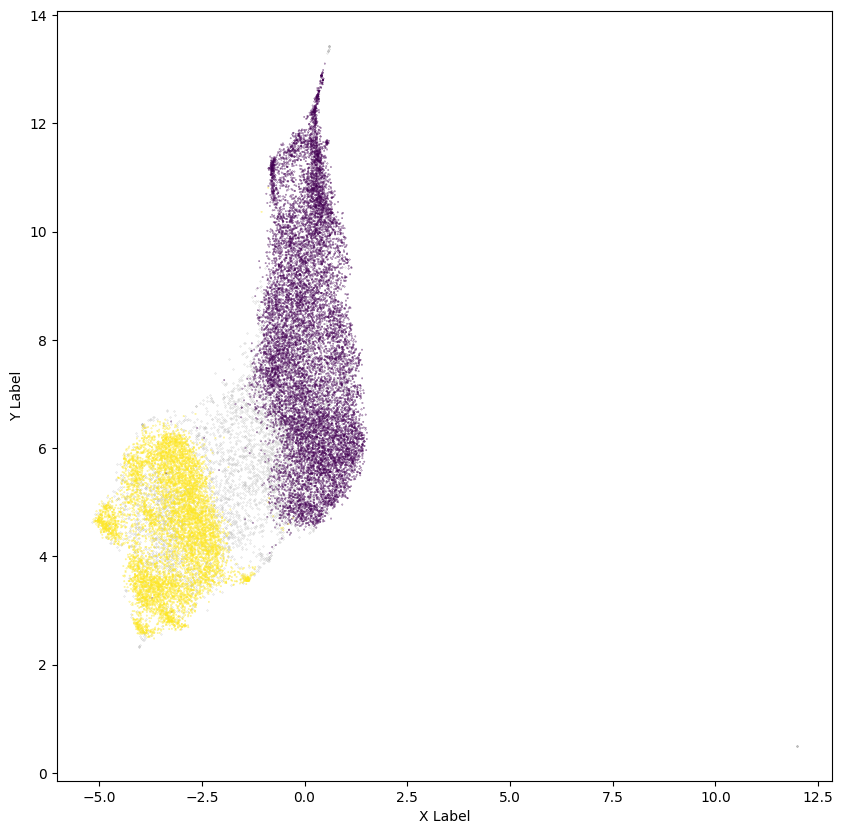

In [ ]:
ax = plt.figure(figsize = (10,10)).add_subplot()

outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

ax.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
ax.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')


plt.show();

Visually, the clusters are well distinguishable, with a significant number of outliers present.

In [ ]:
docs_df = pd.DataFrame(df_test.review[:25000].values, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
docs_df

,Doc,Topic,Doc_ID
0,try few antidepressant over year citalopram fluoxetine amitriptyline but none help with depression insomnia amp anxiety doctor suggest change onto 45 mg mirtazapine medicine have save life thankfu...,0,0
1,son have crohn disease have do very well asacol have no complaint show no side effect have take many nine tablet per day one time be very happy with result reduce bout diarrhea drastically,0,1
2,quick reduction symptom,0,2
3,contrave combine drug be use for alcohol smoke opioid cessation people lose weight because also help control over eat have no doubt most obesity cause from sugarcarb addiction which just powerful ...,0,3
4,have be birth control for one cycle after read some review type similar birth control be bite apprehensive start im give birth control 9 out 10 have not be long enough for 10 far love birth contro...,1,4
...,...,...,...
24995,have use diflucan for yeast infection several time always work wonder for with no side effect ! bonus only one pill work immediately however last time take still felt little off still have some ki...,0,24995
24996,make zombie could sleep for 24 hour after one pill have thing can sleep long,0,24996
24997,absolutely adore microgestin now be for three half month first two month be brutal second week have horrible uterine cramp terrible cramp during period also first month also until get use do give ...,0,24997
24998,take help with insomnia work different hour hospital haven be able overcome insomnia day off silenor have help far hope stay way,0,24998


**Keyword Extraction**

Code source: [Topic Modeling with BERT](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to compute the TF-IDF representation of the given documents
def c_tf_idf(documents, m, ngram_range=(1, 2)):
    # Initialize CountVectorizer with a maximum of 2000 features and specified n-gram range
    count = CountVectorizer(max_features=2000, stop_words='english', ngram_range=ngram_range).fit(documents)

    # Transform the documents into a term-frequency array
    t = count.transform(documents).toarray()

    # Calculate the word frequencies across all documents
    w = t.sum(axis=1)

    # Compute the term frequency (TF) by dividing the term counts by total word counts per document
    tf = np.divide(t.T, w)

    # Compute the document frequency (DF) for each term across all documents
    sum_t = t.sum(axis=0)

    # Compute the inverse document frequency (IDF) using the total number of documents `m`
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)

    # Calculate the TF-IDF matrix by multiplying TF and IDF
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df_test.review[:25000]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j
                           in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc":  "Size"},axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df);
topic_sizes

,Topic,Size
1,0,12920
2,1,8292
0,-1,3788


In [ ]:
top_n_words[0][:10]

[('work', 0.013064764322324427),
 ('feel', 0.012756537814812874),
 ('effect', 0.012665213087435389),
 ('medication', 0.012552259285764316),
 ('pain', 0.012498293984907037),
 ('help', 0.012482894962961254),
 ('medicine', 0.012028316606309632),
 ('make', 0.011726089541294575),
 ('like', 0.011171187891282212),
 ('pill', 0.011126884347374522)]

In [ ]:
top_n_words[1][:10]

[('period', 0.012593333796056391),
 ('week', 0.011983771215615032),
 ('month', 0.01196711361373741),
 ('mg', 0.011874857886999525),
 ('start', 0.011533067124831896),
 ('year', 0.011403167630198418),
 ('time', 0.011164368502497394),
 ('just', 0.010658571805548375),
 ('effect', 0.010237327403049567),
 ('like', 0.010214127821396843)]

The keywords in both clusters, 0 and 1, do not allow us to determine the topic of the clusters as they lack meaningful context and also overlap between the clusters.

##**BigARTM Verification**

We will extract keywords for 2 topics using the BigARTM model.

In [ ]:
import artm

from numpy import array
# Extract word tokens using CountVectorizer
cv = CountVectorizer(max_features=2000, stop_words = 'english', ngram_range =(1,2)) #для слова либо пары слов
n_wd = array(cv.fit_transform(docs_df[docs_df.Topic != -1].Doc).todense()).T
vocabulary = cv.get_feature_names_out()

bv = artm.BatchVectorizer(data_format='bow_n_wd',
                          n_wd=n_wd,
                          vocabulary=vocabulary)


/usr/local/lib/python3.10/dist-packages/artm/batches_utils.py:227: DeprecationWarning:

Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.



In [ ]:
# Learn simple LDA model (or you can use advanced artm.ARTM)
model = artm.LDA(num_topics=2, dictionary=bv.dictionary)
model.fit_offline(bv, num_collection_passes=20)

In [ ]:
top_tokens = model.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print ('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['day', 'work', 'mg', 'year', 'effect', 'feel', 'pain', 'start', 'week', 'time']
Topic #1: ['month', 'period', 'pill', 'day', 'week', 'year', 'control', 'start', 'weight', 'gain']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
def sets_word(set1, set2):

    set1 = set(i for i, j in set1)
    set2 = set(set2)
    a = set1.intersection(set2)
    print(a)
    print(f'Percentage of top words: {100*len(a)/len(set1)}')
    print(f'Длина словаря:{len(set1)}')

In [ ]:
sets_word(top_n_words[1][:10], model.get_top_tokens()[0])

{'week', 'time', 'year', 'mg', 'start', 'effect'}
Percentage of top words: 60.0
Длина словаря:10


In [ ]:
sets_word(top_n_words[1][:10], model.get_top_tokens()[1])

{'week', 'year', 'month', 'start', 'period'}
Percentage of top words: 50.0
Длина словаря:10


In [ ]:
sets_word(top_n_words[0][:10], model.get_top_tokens()[0])

{'feel', 'effect', 'pain', 'work'}
Percentage of top words: 40.0
Длина словаря:10


In [ ]:
sets_word(top_n_words[0][:10], model.get_top_tokens()[1])

{'pill'}
Percentage of top words: 10.0
Длина словаря:10


The keywords of the clusters for the two models matched by 40-50%. Since it is impossible to determine the cluster topics based on these keywords, we will try another model, **BertTopic**, after cleaning the text. The cleaning process includes removing all stop words and words related to time duration such as 'month', 'year', 'go', 'day', 'week', as well as frequently occurring words in the clusters like 'mg',

## **BertTopic**

In [ ]:
%%capture
!pip install bertopic

In [ ]:
from bertopic import BERTopic

In [ ]:
#Test set
data = df_test['review'][:25000]
stop = [i for i in stopwords.words('english')]
stop = stop + ['get', 'take', 'mg', 'month', 'year', 'go', 'day', 'week', 'use']
word_list = [nltk.word_tokenize(i) for i in data]
tokens_wo_stopwords = [[i for i in w if i not in stop] for w in word_list]

In [ ]:
docs = [' '.join([w for w in sents])  for sents in  tokens_wo_stopwords]

In [ ]:
#Extract embeddings using the **all-MiniLM-L6-v2** model, reduce their dimensionality, and perform clustering.
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

2023-06-02 14:37:19,609 - BERTopic - Transformed documents to Embeddings
2023-06-02 14:37:57,270 - BERTopic - Reduced dimensionality
2023-06-02 14:39:44,626 - BERTopic - Clustered reduced embeddings


In [ ]:
#Display the top 5 largest clusters along with outliers
freq = topic_model.get_topic_info();
freq.head(6)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9757,-1_pill_pain_feel_effect,"[pill, pain, feel, effect, side, start, like, period, time, first]","[best prescription medicine ever ! 1 3 time need past make life much well highly recommend try medicine feel need help give shoot like give 10 10, want leave experience drug change life ! ! read b..."
1,0,888,0_acne_skin_face_accutane,"[acne, skin, face, accutane, clear, dermatologist, pimple, epiduo, dry, cream]",[doctor experience mild acne especially forward head combination skin oily dry different place also scar previous acne doctor prescribe cream duac tell wear night bed wash face morning already see...
2,1,877,1_mirena_insertion_iud_cramp,"[mirena, insertion, iud, cramp, skyla, insert, painful, spot, paragard, period]",[mirena insert friday 11182011 far love insertion extremely painful ! really crampy ! however never kid never pregnant hear easier child insert first period cervix open since mild cramp light peri...
3,2,529,2_acne_birth_control_pill,"[acne, birth, control, pill, period, gain, tri, mood, swing, clear]",[terrible acne long remember always around chin cheek area felt horrible finally doctor put ortho tri cyclen definitely work right away enjoy light period say three four acne start clear beautiful...
4,3,523,3_migraine_headache_imitrex_relpax,"[migraine, headache, imitrex, relpax, neurologist, fioricet, suffer, tension, maxalt, work]","[absolutely help migraine anxiety yes migraine, work well migraine, migraine]"
5,4,418,4_adhd_vyvanse_adderall_school,"[adhd, vyvanse, adderall, school, focus, concerta, son, grade, strattera, ritalin]",[11 old son diagnose adhd inattentive august 2010 try concerta 36 nothing pediatrician prescribe vyvanse 40 start difference ! son listen focus pay attention concentrate home school well manage be...


As observed, the clusters are well-defined by keywords, grouped by the user's physical conditions, illnesses, and drug names (which is expected for drug reviews, although it is difficult to determine this without prior analysis). Reviews categorized as "-1" resemble general reviews without specialization in specific illnesses or drugs.
**Visualisation**:

In [ ]:
topic_model.visualize_topics()

There are numerous clusters — **218 in total.**

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.001)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
topic_model.visualize_barchart(top_n_topics=10)

In [ ]:
topic_model.visualize_term_rank()

Reduce the number of clusters to 30.

In [ ]:
topic_model.reduce_topics(docs, nr_topics=30)

2023-06-02 14:41:56,571 - BERTopic - Reduced number of topics from 218 to 30


In [ ]:
#Key words 'top_n_topics=10'
topic_model.visualize_barchart(top_n_topics=10)

In [ ]:
#Topics
freq = topic_model.get_topic_info();
freq.Name

0                   -1_feel_pain_effect_pill
1              0_anxiety_feel_sleep_migraine
2                  1_period_cramp_birth_pill
3                     2_skin_acne_face_clear
4                   3_taste_drink_water_prep
5                   4_pain_leg_knee_tramadol
6                       5_lose_weight_eat_lb
7              6_smoke_quit_chantix_suboxone
8                   7_cough_asthma_sinus_ear
9         8_cancer_injection_treatment_viral
10           9_blood_pressure_cholesterol_bp
11             10_effect_side_drug_insurance
12              11_burn_itch_yeast_infection
13    12_erection_viagra_cialis_testosterone
14            13_flash_thyroid_hot_synthroid
15                14_sweat_drysol_shirt_wear
16               15_eye_drop_xiidra_restasis
17                16_bleed_stop_heavy_period
18                  17_hair_loss_louse_pluck
19                   18_work_great_love_sexy
20                 19_patch_stick_mylan_tape
21     20_effective_helpful_help_improvement
22        

The topics can be categorized into: groups of diseases, groups of patient conditions, and -1 representing general reviews.

We will compare this with the results of BigARTM for the cleaned text and 30 topics.

In [ ]:
#cv = CountVectorizer(max_features=2000, stop_words = 'english', ngram_range =(1,2))
n_wd = array(cv.fit_transform(docs).todense()).T
vocabulary = cv.get_feature_names_out()

bv = artm.BatchVectorizer(data_format='bow_n_wd',
                          n_wd=n_wd,
                          vocabulary=vocabulary)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/artm/batches_utils.py:227: DeprecationWarning:

Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.



In [ ]:
model_ = artm.LDA(num_topics=30, dictionary=bv.dictionary)
model_.fit_offline(bv, num_collection_passes=20)

In [ ]:
top_tokens = model_.get_top_tokens(num_tokens=5)
for i, token_list in enumerate(top_tokens):
     print ('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['start', 'ago', 'away', 'horrible', 'right']
Topic #1: ['really', 'bad', 'notice', 'pretty', 'definitely']
Topic #2: ['tire', 'make', 'energy', 'dry', 'mouth']
Topic #3: ['medicine', 'far', 'good', 'lot', 'best']
Topic #4: ['eat', 'lose', 'start', 'lb', 'food']
Topic #5: ['drug', '10', 'headache', 'migraine', 'effect']
Topic #6: ['weight', 'gain', 'weight gain', 'loss', 'pound']
Topic #7: ['felt', 'drink', 'water', 'taste', 'sure']
Topic #8: ['skin', 'acne', 'clear', 'face', 'product']
Topic #9: ['pain', 'sleep', 'night', 'wake', 'leg']
Topic #10: ['medication', 'know', 'think', 'people', 'thing']
Topic #11: ['infection', 'dr', 'burn', 'itch', 'treatment']
Topic #12: ['hour', 'prescribe', 'later', '12', 'doctor']
Topic #13: ['effect', 'dose', 'experience', 'increase', 'effective']
Topic #14: ['cramp', 'painful', 'insertion', 'pain', 'insert']
Topic #15: ['great', 'need', 'insurance', 'work great', 'ask']
Topic #16: ['work', 'time', 'med', '30', 'hard']
Topic #17: ['bleed', '

## Conclusion:

BertTopic performed the best in dividing the text into topics related to patient conditions (diseases, side effects, organ systems, etc.) and types of drugs. The model categorized the text in a way that aligns with expectations for drug reviews. However, achieving better results requires prior analysis and text preprocessing.